# Анализ непераметрического подхода к восстановлению плотности Парзеновским окном

**Целью** данного исследования было выявление функции и соответствующего параметра, которые с большей скоростью и точностью могли бы восстановить плотность распределения.

Было исследовано восемь видов ядер:
- прямоугольное/равномерноe
- треугольное
- Епанечникова
- Гауссово
- косинусоидное
- логистическое
- сигмоидальное
- Сильвермана

Во всех ядрах варьировался параметр ширины окна кроме Гауссова, в котором дополнительно использовался параметр alfa = 1 / sqrt(D).

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from tqdm import tqdm

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib

import chart_studio.plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import iplot
import cufflinks
cufflinks.go_offline()
# # Устанавливаем глобальную тему 
cufflinks.set_config_file(world_readable=True, theme='pearl', offline=True)

import random
import scipy.stats as ss
np.random.seed(1)
%config InlineBackend.figure_format = 'svg'

Генерируем набор данных с произвольными параметрами из нормального распределения.

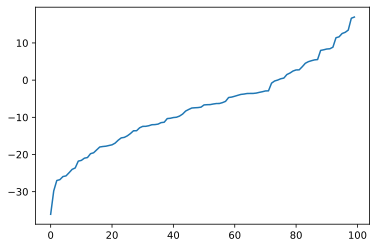

In [2]:
mu, sigma = -8, 11 # mean and standard deviation
np.random.seed(0)
normal = np.random.normal(mu, sigma, 100)
normal.sort()
plt.plot(normal)

Функции ядер собраны в одну функцию для удобства.

In [3]:
# Подготовим функции для всех ядер

def I(r):
    return int(abs(r) <= 1)

def K(type_f, r, h, *args):
    """
    Считает значение функции в точке x относительно x_i, при заданных параметрах
    
    args - param,
    Прямоугольное/равномерноe - 'P'
    Треугольное - 'T'
    Епанечникова - 'E'
    Гауссово  args - gamma > 0 - 'G'
    Косинусоидное - 'cos'
    Логистическое - 'L'
    Сигмоидальное - 'sigm'
    Сильвермана - 'sil'
    """
    if type_f == 'P':
        return (1 / 2)*I(r)
    elif type_f == 'T':
        return (1 - abs(r))*I(r)
    elif type_f == 'E':
        return 0.75 * (1 - r**2) * I(r)
    elif type_f == 'G':
        return (args[0] / np.sqrt(np.pi)) * np.exp(- (args[0] * r)**2)
    elif type_f == 'cos':
        return 0.25 * np.pi * np.cos(0.5 * np.pi * r) * I(r)
    elif type_f == 'L':
        return 1 / (np.exp(r) + 2 + np.exp(-r))
    elif type_f == 'sigm' : 
        return 2 / (np.pi * (np.exp(r) + np.exp(-r)))
    elif type_f == 'sil' :
        return np.exp(- abs(r) / np.sqrt(2)) * np.sin(abs(r)/ np.sqrt(2) + np.pi / 4) / 2
    else:
        print("Проверьте правильность написания функции")


In [4]:
list_of_K = ['P', 'T', 'E', 'G', 'cos', 'L', 'sigm', 'sil']

In [5]:
size = np.arange(-18, 18, 0.1)
for_plotting = pd.DataFrame(index=size)
x_i = 0
h = 2

for K_f in list_of_K:
    p_val = []
    print(K_f)
    for i in size:
        r = (i-x_i) / h
        p_val.append(K(K_f, r, h, 0.9) / h)
    for_plotting[K_f] = p_val

P
T
E
G
cos
L
sigm
sil


In [6]:
for_plotting[list_of_K].iplot(
    mode='lines',
    opacity=0.8,
    size=5,
    colorscale='dark2',
    yTitle='Плотность',
    title='Виды использованных ядер')

In [7]:
np.arange(-300, 1000, 0.01)

array([-300.  , -299.99, -299.98, ...,  999.97,  999.98,  999.99])

In [8]:
# Функция для построения плотности при заданных параметрах.
def p_cap(K_f, data, h, *args):
    data = np.array(data)
    data.sort()
    
    dots = np.arange(-30, 30, 0.01)
    p_c = {}.fromkeys(dots, 0)
    
#   Создаем словарь с накопленными значениями функций
    for x_i in data:
        r = 0
        for x in dots:
            r = (x - x_i) / h
            p_c[x] += K(K_f, r, h, args[0])/(h * data.shape[0])
    return p_c

In [9]:
# Применив одно из эмпирических правил подбора h, нашли h ~ 4.64
dict_of_emp_h = {}
for K_f in list_of_K:
    dict_of_emp_h[K_f] = p_cap(K_f, normal, 4.64, 1/np.sqrt(2))
    
val_of_opt_h = pd.DataFrame(index=np.arange(-30, 30, 0.01))
for K_f in list_of_K:
    val_of_opt_h[K_f] = dict_of_emp_h[K_f].values()

# Добавим истинное распределение и изобразим результат на графике
val_of_opt_h['true_dist'] = (1 / (sigma * np.sqrt(2 * np.pi)))* np.exp(- ((val_of_opt_h.index - mu) / sigma )**2 / 2)
val_of_opt_h.iplot(
    mode='lines',
    opacity=0.8,
    size=5,
    colorscale='dflt',
    yTitle='Плотность',
    title='Поведение функций при заданном окне по рекомендациям')

MSE = pd.DataFrame(columns = list_of_K, index=[4.64])

for K_f in list_of_K:
    MSE[K_f][0] = sum((val_of_opt_h[K_f] - val_of_opt_h['true_dist']) ** 2)

In [10]:
MSE

P          T          E          G      cos          L  \
4.64  0.037366  0.0463973  0.0386887  0.0278901  0.04034  0.0915966   

           sigm        sil  
4.64  0.0629347  0.0185224

Максимальное значение получилось у логистической функции ядра, минимум дало ядро Сильвермана. Интересно, что функция равномерного ядра оказалась не самой худшей в плане MSE.  
Теперь возьмем некоторый дельта интервал для h и построим графики зависимости функции ошибки от параметра h.

In [11]:
delta = 1
h_emp = 4.64
h = np.arange(h_emp-delta, h_emp+delta, 0.15)
dict_of_data = {}
for K_f in list_of_K:
    dict_of_data[K_f] = {}
    for h_i in h:
        dict_of_data[K_f][h_i] = p_cap(K_f, normal, h_i, 1/np.sqrt(2))

MSE_tot = pd.DataFrame(columns = list_of_K, index=h)

for K_f in list_of_K:
    for h_i in h:
        MSE_tot.loc[h_i, K_f] = sum((list(dict_of_data[K_f][h_i].values()) - val_of_opt_h['true_dist']) ** 2)

In [12]:
MSE_tot.iplot(
    mode='lines+markers',
    opacity=0.8,
    size=8,
    theme = 'polar',
    symbol=1,
    xTitle='h',
    colorscale='dflt',
    yTitle='Значение функции ошибки',
    title= ('Сравнение качества при разных  h'))

In [13]:
delta = 4
h_emp = 4.64
h_2 = np.arange(h_emp-delta, h_emp+delta, 1)
dict_of_data_2 = {}
for K_f in list_of_K:
    print(K_f)
    dict_of_data_2[K_f] = {}
    for h_i in h_2:
        dict_of_data_2[K_f][h_i] = p_cap(K_f, normal, h_i, 1/np.sqrt(2))

P
T
E
G
cos
L
sigm
sil


In [14]:
MSE_tot_2 = pd.DataFrame(columns = list_of_K, index=h_2)

for K_f in list_of_K:
    for h_i in h_2:
        MSE_tot_2.loc[h_i, K_f] = sum((list(dict_of_data_2[K_f][h_i].values()) - val_of_opt_h['true_dist']) ** 2)

In [15]:
MSE_tot_2.iplot(
    mode='lines+markers',
    opacity=0.8,
    size=8,
    theme = 'polar',
    symbol=1,
    xTitle='h',
    colorscale='dflt',
    yTitle='Значение функции ошибки',
    title= ('Сравнение качества при разных  h'))

Посмотрим теперь подробнее на Гауссово ядро 

In [16]:
h_g = np.arange(0.1, 8.1, 1)
alfa = np.arange(0.1, 8.1, 1)


In [17]:
MSE_g = pd.DataFrame(columns = alfa, index=h_g)

for alfa_i in alfa:
    for h_i in h_g:
        print(alfa_i, h_i)
        curr_val = list(p_cap('G', normal, h_i, alfa_i).values())
        MSE_g.loc[h_i, alfa_i] = sum((curr_val - val_of_opt_h['true_dist']) ** 2) 

0.1 0.1
0.1 1.1
0.1 2.1
0.1 3.1
0.1 4.1
0.1 5.1
0.1 6.1
0.1 7.1
1.1 0.1
1.1 1.1
1.1 2.1
1.1 3.1
1.1 4.1
1.1 5.1
1.1 6.1
1.1 7.1
2.1 0.1
2.1 1.1
2.1 2.1
2.1 3.1
2.1 4.1
2.1 5.1
2.1 6.1
2.1 7.1
3.1 0.1
3.1 1.1
3.1 2.1
3.1 3.1
3.1 4.1
3.1 5.1
3.1 6.1
3.1 7.1
4.1 0.1
4.1 1.1
4.1 2.1
4.1 3.1
4.1 4.1
4.1 5.1
4.1 6.1
4.1 7.1
5.1 0.1
5.1 1.1
5.1 2.1
5.1 3.1
5.1 4.1
5.1 5.1
5.1 6.1
5.1 7.1
6.1 0.1
6.1 1.1
6.1 2.1
6.1 3.1
6.1 4.1
6.1 5.1
6.1 6.1
6.1 7.1
7.1 0.1
7.1 1.1
7.1 2.1
7.1 3.1
7.1 4.1
7.1 5.1
7.1 6.1
7.1 7.1


In [18]:
MSE_g_1 = MSE_g.stack().reset_index().rename(columns={'level_0':'alfa','level_1':'h', 0:'MSE'})

In [19]:
def color_negative_red(val):
    color = 'red' if val == min(MSE_g_1['MSE']) else 'white'
    return 'background-color: %s' % color            

MSE_g.style.applymap(color_negative_red)

In [20]:
MSE_g.iplot(
    mode='lines+markers',
    opacity=0.8,
    size=8,
    theme = 'polar',
    symbol=1,
    xTitle='h',
    colorscale='dflt',
    yTitle='Значение функции ошибки',
    title= ('Сравнение качества при разных  alfa'))

In [21]:
# Библиотека для визуализации была взята из статьи https://tproger.ru/translations/python-data-vizualization/